# Module 2 - Final Project

<b>Goal</b>: Gather information from a real-world database and use your knowledge of statistical analysis and hypothesis testing to generate analytical insights that can be of value to the company.

<img src='Northwind_ERD.png' height=100% width=100%>

In [1]:
import warnings
warnings.filterwarnings("ignore")
import sqlite3 as sql
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from statsmodels.formula.api import ols
import statsmodels.api as sm
from statsmodels.graphics.factorplots import interaction_plot
import seaborn as sns
from statsmodels.stats.multicomp import MultiComparison
from scipy.stats import ttest_ind
from statsmodels.stats.multicomp import pairwise_tukeyhsd

In [2]:
conn = sql.connect('Northwind_small.sqlite')
cur = conn.cursor()
table_names = list(cur.execute('''SELECT name FROM sqlite_master WHERE TYPE = 'table' ''').fetchall())

table_names

[('Employee',),
 ('Category',),
 ('Customer',),
 ('Shipper',),
 ('Supplier',),
 ('Order',),
 ('Product',),
 ('OrderDetail',),
 ('CustomerCustomerDemo',),
 ('CustomerDemographic',),
 ('Region',),
 ('Territory',),
 ('EmployeeTerritory',)]

In [3]:
sql_comm = []
for i in range(0, len(table_names)):
    s = "SELECT * FROM " + table_names[i][0]
    sql_comm.append(s)
    
employees = pd.read_sql_query(sql_comm[0], conn)
categories = pd.read_sql_query(sql_comm[1], conn)
customers = pd.read_sql_query(sql_comm[2], conn)
shippers = pd.read_sql_query(sql_comm[3], conn)

suppliers = pd.read_sql_query(sql_comm[4], conn)
products = pd.read_sql_query(sql_comm[6], conn)
order_details = pd.read_sql_query(sql_comm[7], conn)
orders = pd.read_csv('orders.csv', sep=';')

cust_cust_demos = pd.read_sql_query(sql_comm[8], conn)
cust_demos = pd.read_sql_query(sql_comm[9], conn)
regions = pd.read_sql_query(sql_comm[10], conn)
territories = pd.read_sql_query(sql_comm[11], conn)
emp_territories = pd.read_sql_query(sql_comm[12], conn)

## Hypothesis Test 1

### Do discounts have a statistically significant effect on the number of products customers order? If so, at what level(s) of discount?

The 2 questions needs to be split into 2 different hypothesis testings.
- For the first question, I will do a two-tail test to compare discounts vs no discounts.
- For the second question, I will do an ANOVA test to compare each discount level with one another.

### Part 1
>**$H_{o}$: Discounts do not effect the number of products customers order.**

>**$H_{a}$: Discounts can either increase or decrease the number of products customers order.**

Judging from the question, I need to investigate the 'Quantity' and 'Discount' columns from the 'Order Details' table.

In [4]:
order_details.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2155 entries, 0 to 2154
Data columns (total 6 columns):
Id           2155 non-null object
OrderId      2155 non-null int64
ProductId    2155 non-null int64
UnitPrice    2155 non-null float64
Quantity     2155 non-null int64
Discount     2155 non-null float64
dtypes: float64(2), int64(3), object(1)
memory usage: 101.1+ KB


In [5]:
len(order_details.ProductId.unique())

77

We have 77 unique products from 2155 rows of data. This calls into question, is the question asking for specific orders or products as a whole.
- I will move on with specific orders first
- First, I will create a graph to visualize the difference in Discount vs No Discount
- Next, I will perform the t-test to find the p-value. If the p-value is less than 0.05 (alpha), then we will reject the null hypothesis.

In [6]:
h1 = order_details[['ProductId','Quantity','Discount']]

Split the dataset; Discount and No Discount

In [7]:
h1no = h1[h1['Discount']==0]
h1yes = h1[h1['Discount']>0]

Create arrays to use for Histogram

In [8]:
h1nohist = np.array(h1no['Quantity'])
h1yeshist = np.array(h1yes['Quantity'])

#### Histogram to visualize the difference in average quantities and count

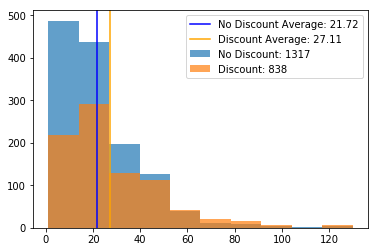

In [9]:
plt.hist(h1nohist, label = f"No Discount: {len(h1nohist)}", alpha=0.7)
plt.hist(h1yeshist, label = f"Discount: {len(h1yeshist)}", alpha=0.7)
plt.axvline(np.mean(h1nohist), color='blue', label = f"No Discount Average: {round(np.mean(h1nohist),2)}")
plt.axvline(np.mean(h1yeshist), color='orange', label = f"Discount Average: {round(np.mean(h1yeshist),2)}")
plt.legend()
plt.show()

From this graph, we can see that there was a smaller quantity of discounted products that were sold. However, the quantity average per order for discounted products is higher.

Function that will tell us if we reject or fail to reject the Null Hypothesis

In [10]:
def test(results, alpha):
    if (results[1] > 0.05):
        print(f"Fail to reject the Null Hypothesis.\nResults are not statistically significant with p-value = {results[1]}")
    else:
        print(f"Reject the Null Hypothesis.\nResults are statistically significant with p-value = {results[1]}")

#### Perform the t-test to find the p-value

In [11]:
results = stats.ttest_ind(h1no['Quantity'],h1yes['Quantity'])

test(results, 0.05)

Reject the Null Hypothesis.
Results are statistically significant with p-value = 1.1440924523215966e-10


The p-value is much less than the 0.05 significance level, therefore we can reject the null hypothesis. This tells us that a discount does impact the quantity of products ordered.<br><br>
Moving on to part 2 of the question...

### Part 2
>**$H_{o}$: Levels of discount have equal effects on the number of products customers order equally.**

>**$H_{a}$: Levels of discount have different effects on the number of products customers order.**

This question only applies to products with a discount. So I will move on with the dataset where 'Discount' is greater than 0.

In [12]:
h1yes.Discount.value_counts()

0.05    185
0.10    173
0.20    161
0.15    157
0.25    154
0.03      3
0.02      2
0.04      1
0.06      1
0.01      1
Name: Discount, dtype: int64

The value counts are extremely low for discount levels of 0.01, 0.02, 0.03, 0.04, and 0.06. Because the count is so low, I will delete those records from the data.

In [13]:
h1yes = h1yes.drop(h1yes[(h1yes['Discount'] < 0.05) | (h1yes['Discount'] == 0.06)].index)

In [14]:
h1yes.Discount.value_counts()

0.05    185
0.10    173
0.20    161
0.15    157
0.25    154
Name: Discount, dtype: int64

#### Bar graph to visualize the quantity means in discount levels

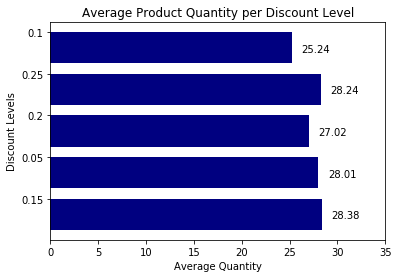

In [15]:
X = []
y = []
for i in h1yes['Discount'].unique():
    X.append(i)
    y.append(round(h1yes['Quantity'][h1yes['Discount'] == i].mean(),2))

fig, ax = plt.subplots()
width = 0.75
ind = np.arange(len(y))
ax.barh(ind, y, width, color="navy")
ax.set_yticks(ind+width/2)
ax.set_yticklabels(X, minor=False)
ax.set_xlim([0,35])
plt.title('Average Product Quantity per Discount Level')
plt.xlabel('Average Quantity')
plt.ylabel('Discount Levels')

for i, v in enumerate(y):
    ax.text(v + 1, i - 0.10, str(v), color='black')

#### Perform the ANOVA Test to find p-value

In [16]:
formula = 'Quantity ~ C(Discount)'
lm = ols(formula, h1yes).fit()
table = sm.stats.anova_lm(lm, typ=2)
table

,sum_sq,df,F,PR(>F)
C(Discount),1159.517551,4.0,0.674103,0.610041
Residual,354768.342690,825.0,NaN,NaN


We fail to reject the null hypothesis because the p-value of 0.61 is greater than our significance level of 0.05.

Turning each discount level into an array for a Tukey test

In [17]:
h05 = np.array(h1yes['Quantity'][h1yes['Discount'] == 0.05])
h10 = np.array(h1yes['Quantity'][h1yes['Discount'] == 0.10])
h15 = np.array(h1yes['Quantity'][h1yes['Discount'] == 0.15])
h20 = np.array(h1yes['Quantity'][h1yes['Discount'] == 0.20])
h25 = np.array(h1yes['Quantity'][h1yes['Discount'] == 0.25])


#### Perform the Tukey Test to compare each individual discount level

In [18]:
v = np.concatenate((h05, h10, h15, h20, h25))
labels = ['h05'] * len(h05) + ['h10'] * len(h10) + ['h15'] * len(h15) + ['h20'] * len(h20) + ['h25'] * len(h25)
tukey_results = pairwise_tukeyhsd(v, labels, 0.05)

In [19]:
print(tukey_results)

Multiple Comparison of Means - Tukey HSD,FWER=0.05
group1 group2 meandiff  lower  upper  reject
--------------------------------------------
 h05    h10   -2.7738  -8.7696 3.222  False 
 h05    h15    0.3714  -5.7803 6.523  False 
 h05    h20    -0.986  -7.0962 5.1242 False 
 h05    h25    0.2294  -5.9546 6.4134 False 
 h10    h15    3.1452  -3.1037 9.394  False 
 h10    h20    1.7879  -4.4202 7.9959 False 
 h10    h25    3.0033  -3.2774 9.2839 False 
 h15    h20   -1.3573   -7.716 5.0014 False 
 h15    h25   -0.1419  -6.5715 6.2877 False 
 h20    h25    1.2154  -5.1745 7.6054 False 
--------------------------------------------


All comparisons resulted in failing to reject the null hypothesis.

<b>The results of our hypotheses tests tell us that discounts do have a statistically significant effect on the quantity of a product in an order. However, the amount of discount does not have an impact.

## Hypothesis Test 2

### Do some regions have higher average order sales than other regions?

>**$H_{o}$: The average order sale is the same across all regions.**

>**$H_{a}$: The average order sale is different amongst regions.**

This hypothesis requires me to use the 'Region' and 'Order Details' tables. In order for me to do that, I need to join all the tables in between into one dataset.

In [20]:
h2 = pd.merge(regions,
              territories,
              left_on = 'Id',
              right_on = 'RegionId',
              how = 'left')
h2 = pd.merge(h2,
             emp_territories,
             left_on = 'Id_y',
             right_on = 'TerritoryId',
             how = 'left')
h2 = pd.merge(h2,
             employees,
             left_on = 'EmployeeId',
             right_on = 'Id',
             how = 'left')
h2 = pd.merge(h2,
             orders,
             left_on = 'EmployeeId',
             right_on = 'EmployeeId',
             how = 'left')
h2 = pd.merge(h2,
             order_details,
             left_on = 'Id',
             right_on = 'OrderId',
             how = 'left')

Grabbing only the necessary fields

In [21]:
h2 = h2[['RegionDescription',
    'LastName',
    'FirstName',
    'Title',
    'OrderDate',
    'OrderId',
    'ProductId',
    'UnitPrice',
    'Quantity',
    'Discount'
   ]]

'TerritoryDescription' and 'Id_y' caused duplicates in dataset. <br>Getting rid of all the duplicates, essentially grouping all fields

In [22]:
h2 = h2.drop_duplicates(subset = ("OrderId","ProductId")).reset_index()

Creating a sales total field

In [23]:
h2['Total'] = h2['UnitPrice']*(1 - h2['Discount']) * h2['Quantity']

Summing the totals for the same OrderId

In [24]:
h2 = h2.groupby(['RegionDescription','OrderId','OrderDate']).sum().reset_index()

#### Bar graph to visualize the average sales per order per region

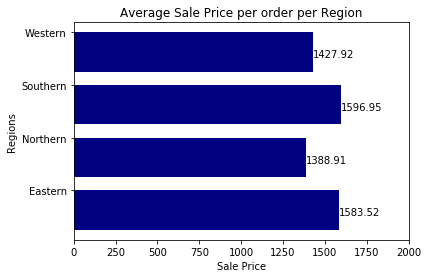

In [25]:
X = []
y = []
for i in h2['RegionDescription'].unique():
    X.append(i)
    y.append(round(h2['Total'][h2['RegionDescription'] == i].mean(),2))

fig, ax = plt.subplots()
width = 0.75
ind = np.arange(len(y))
ax.barh(ind, y, width, color="navy")
ax.set_yticks(ind+width/2)
ax.set_yticklabels(X, minor=False)
ax.set_xlim([0,2000])
plt.title('Average Sale Price per order per Region')
plt.xlabel('Sale Price')
plt.ylabel('Regions')

for i, v in enumerate(y):
    ax.text(v + 1, i - 0.10, str(v), color='black')

#### Perform ANOVA test to find p-value

In [26]:
formula = 'Total ~ C(RegionDescription)'
lm = ols(formula, h2).fit()
table = sm.stats.anova_lm(lm, type=2)
table

,df,sum_sq,mean_sq,F,PR(>F)
C(RegionDescription),3.0,6.117880e+06,2.039293e+06,0.598096,0.616367
Residual,826.0,2.816365e+09,3.409643e+06,NaN,NaN


We fail to reject the null hypothesis because the p-value of 0.62 is greater than our alpha level of 0.05.<br><br>
Let's try a Tukey Test.

Turning each region into an array

In [27]:
west = np.array(h2['Total'][h2['RegionDescription'] == 'Western'])
south = np.array(h2['Total'][h2['RegionDescription'] == 'Southern'])
north = np.array(h2['Total'][h2['RegionDescription'] == 'Northern'])
east = np.array(h2['Total'][h2['RegionDescription'] == 'Eastern'])

#### Perform the Tukey Test to compare each region with one another

In [28]:
v = np.concatenate((west, south, north, east))
labels = ['west'] * len(west) + ['south'] * len(south) + ['north'] * len(north) + ['east'] * len(east)
tukey_results = pairwise_tukeyhsd(v, labels, 0.05)

In [29]:
print(tukey_results)

Multiple Comparison of Means - Tukey HSD,FWER=0.05
group1 group2  meandiff   lower    upper   reject
-------------------------------------------------
 east  north  -194.6076 -650.5672 261.3519 False 
 east  south    13.43   -468.3437 495.2036 False 
 east   west  -155.5981 -621.1579 309.9617 False 
north  south   208.0376 -367.8374 783.9127 False 
north   west   39.0096  -523.3712 601.3903 False 
south   west   -169.028 -752.5337 414.4776 False 
-------------------------------------------------


All comparisons resulted in failing to reject the null hypothesis

However, let's take a look at the count of orders per region. Although the average sale price per order is statistically insignificant, the number of orders may have an impact.

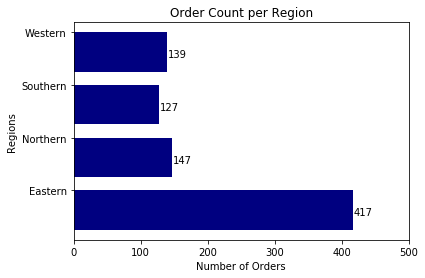

In [30]:
X = []
y = []
for i in h2['RegionDescription'].unique():
    X.append(i)
    y.append(round(h2['OrderId'][h2['RegionDescription'] == i].count(),2))
    
fig, ax = plt.subplots()
width = 0.75
ind = np.arange(len(y))
ax.barh(ind, y, width, color="navy")
ax.set_yticks(ind+width/2)
ax.set_yticklabels(X, minor=False)
ax.set_xlim([0,500])
plt.title('Order Count per Region')
plt.xlabel('Number of Orders')
plt.ylabel('Regions')

for i, v in enumerate(y):
    ax.text(v + 1, i - 0.10, str(v), color='black')

Although the average sale price per region is statistically insignificant, clearly the Eastern region has a much higher order count.<br>
Maybe the Eastern region had a headstart in sales. Let's take a look at the sales per quarter.

Creating a 'Quarter' field to indicate the yearly quarters.

In [31]:
h2['Quarter'] = h2['OrderDate'].apply(lambda x: 1 if '2012-07-01' <= x < '2012-10-01'
                                      else (2 if '2012-10-01' <= x < '2013-01-01' 
                                            else (3 if '2013-01-01' <= x < '2013-04-01'
                                                 else (4 if '2013-04-01' <= x < '2013-07-01'
                                                      else (5 if '2013-07-01' <= x < '2013-10-01'
                                                           else (6 if '2013-10-01' <= x < '2014-01-01'
                                                                else (7 if '2014-01-01' <= x < '2014-04-01'
                                                                     else (8 if '2014-04-01' <= x < '2014-07-01'
                                                                          else 0))))))))

#### Line graph to show the progress of each region per quarter

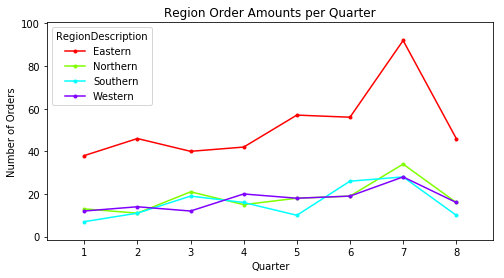

In [32]:
fig = interaction_plot(h2['Quarter'],h2['RegionDescription'],h2['OrderId'],func=len)
fig.set_size_inches(8,4)
plt.xticks(np.arange(1,9,step=1), ('1','2','3','4','5','6','7','8'))
plt.xlabel('Quarter')
plt.ylabel('Number of Orders')
plt.title('Region Order Amounts per Quarter')
plt.show()

The graph tells us that the Eastern region has had more sales than other regions every quarter. Quarter 7, 1st quarter of 2014, had a huge spike in orders for all regions.

<b> The results of this hypothesis test tells us that the average sale price per order is statistically insignificant. However, the Eastern region has had a much higher order amount every quarter compared to the other regions.

## Hypothesis Test 3

### Did the Price Increase on April 5th, 2013 cause a statistically significant effect on number of products customers order?

According to the data on 'Order Details' table, the price of every product increased some time between April 4th, 2013 and April 7th, 2013. No orders were taken place during this time period. This hypothesis test will determine if the price hike caused a statistically significant effect on number of products customers order.

>**$H_{o}$: Price increase did not effect the number of products customers order.**

>**$H_{a}$: Price increase did effect the number of products customers order.**

In [33]:
h3 = pd.merge(orders,
             order_details,
             left_on='Id',
             right_on='OrderId',
             how='left')

Grabbing only the fields we need

In [34]:
h3 = h3[['ProductId','OrderDate','UnitPrice','Quantity']]

Taking a look at the order dates of the different prices for each product

In [35]:
h3[['ProductId','OrderDate','UnitPrice']].groupby(['ProductId','UnitPrice']).max()

OrderDate
ProductId UnitPrice            
1         14.40      2013-03-17
          18.00      2014-05-05
2         15.20      2013-03-25
          19.00      2014-05-06
3         8.00       2013-03-25
          10.00      2014-05-06
4         17.60      2013-03-04
          22.00      2014-05-06
5         17.00      2012-12-13
          21.35      2014-04-24
6         20.00      2012-10-09
          25.00      2014-05-06
7         24.00      2013-03-11
          30.00      2014-05-06
8         32.00      2012-11-04
          40.00      2014-05-06
9         77.60      2013-01-21
          97.00      2014-01-23
10        24.80      2013-03-18
          31.00      2014-05-06
11        14.00      2012-07-04
          16.80      2013-03-28
          21.00      2014-05-05
12        30.40      2013-02-07
          38.00      2014-05-06
13        4.80       2013-03-03
          6.00       2014-05-06
14        18.60      2013-03-13
          23.25      2014-05-06
15        12.40      2012-10-07
...                         ...
63        35.10      2013-01-29
          43.90      2014-04-22
64        26.60      2013-03-19
          33.25      2014-05-06
65        16.80      2013-04-02
          21.05      2014-04-15
66        13.60      2013-04-02
          17.00      2014-05-06
67        11.20      2012-08-19
          14.00      2014-04-28
68        10.00      2013-03-31
          12.50      2014-05-01
69        28.80      2013-04-02
          36.00      2014-04-17
70        12.00      2013-03-25
          15.00      2014-04-30
71        17.20      2013-03-13
          21.50      2014-04-21
72        27.80      2013-04-04
          34.80      2014-04-14
73        12.00      2013-03-27
          15.00      2014-05-06
74        8.00       2013-03-26
          10.00      2014-04-03
75        6.20       2013-03-31
          7.75       2014-05-06
76        14.40      2013-03-14
          18.00      2014-05-06
77        10.40      2013-04-04
          13.00      2014-05-06

[156 rows x 1 columns]

Separating the dataset into before and after the price increase

In [36]:
h3before = h3[h3['OrderDate'] < '2013-04-05']
h3after = h3[h3['OrderDate'] > '2013-04-05']

#### Bar graph to visualize the average quantity per order before and after

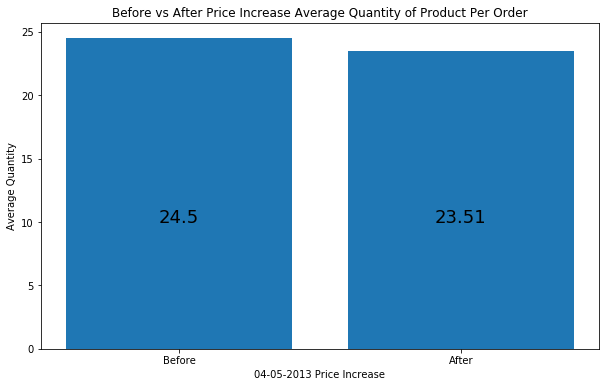

In [37]:
X = ['Before', 'After']
y = [h3before['Quantity'].mean(),
     h3after['Quantity'].mean()]
plt.figure(figsize=(10,6))
plt.bar(X,y)
plt.text(s=round(y[1],2), x=1, y=10, horizontalalignment='center',size=18)
plt.text(s=round(y[0],2), x=0, y=10, horizontalalignment='center',size=18)
plt.ylabel('Average Quantity')
plt.xlabel('04-05-2013 Price Increase')
plt.title('Before vs After Price Increase Average Quantity of Product Per Order')
plt.show()

The bar graph tells us there wasn't much of a differencce. The average order decreased slightly after the price increase.

#### Perform a t-test to find the p-value

In [38]:
results = stats.ttest_ind(h3before['Quantity'],h3after['Quantity'])

test(results, 0.05)

Fail to reject the Null Hypothesis.
Results are not statistically significant with p-value = 0.2632745012187658


<b> The hypothesis test tells us that, surprisingly, the quantity of products per order stayed almost the same despite the price increase. Also, according to the line graph from hypothesis test 2, the number of orders generally stayed the same between quarter 3 and 4 which is when the price increase took place.

## Hypothesis Test 4

### Do some employees have higher total sales per quarter than others?

Here we have hypothesis test with 2 categorical factors, employee and quarter of year.

>**$H_{o}$: Employees have the same total sales per month.**

>**$H_{a}$: Employees have different total sales per month.**

In [39]:
h4 = pd.merge(employees,
             orders,
             left_on='Id',
             right_on='EmployeeId',
             how='left')
h4 = pd.merge(h4,
             order_details,
             left_on='Id_y',
             right_on='OrderId',
             how='left')

Grabbing the fields we need

In [40]:
h4 = h4[['LastName','FirstName','Title','OrderDate','ProductId','OrderId','UnitPrice','Quantity','Discount']]

Creating the 'Total' field for total sales

In [41]:
h4['Total'] = h4['UnitPrice']*(1-h4['Discount'])*h4['Quantity']

Creating the 'Quater' field to indicate which quarter of the year

In [42]:
h4['Quarter'] = h4['OrderDate'].apply(lambda x: 1 if '2012-07-01' <= x < '2012-10-01'
                                      else (2 if '2012-10-01' <= x < '2013-01-01' 
                                            else (3 if '2013-01-01' <= x < '2013-04-01'
                                                 else (4 if '2013-04-01' <= x < '2013-07-01'
                                                      else (5 if '2013-07-01' <= x < '2013-10-01'
                                                           else (6 if '2013-10-01' <= x < '2014-01-01'
                                                                else (7 if '2014-01-01' <= x < '2014-04-01'
                                                                     else (8 if '2014-04-01' <= x < '2014-07-01'
                                                                          else 0))))))))

Grouping the records and summing the total sales per employee per quarter

In [43]:
h4 = h4[['LastName','Quarter','Total']].groupby(['LastName','Quarter']).sum().reset_index()

#### Line graph to show the progress of each employee's total sales per quarter

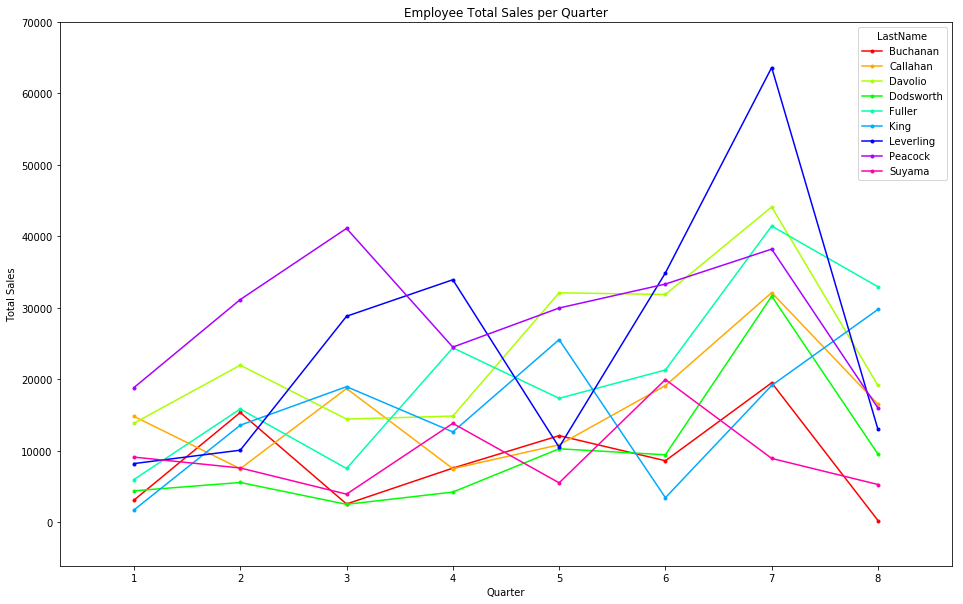

In [44]:
fig = interaction_plot(h4['Quarter'],h4['LastName'],h4['Total'])
fig.set_size_inches(16, 10)
plt.xticks(np.arange(1,9,step=1), ('1','2','3','4','5','6','7','8'))
plt.xlabel('Quarter')
plt.ylabel('Total Sales')
plt.title('Employee Total Sales per Quarter')
plt.show()

Similar to the line graph in hypothesis test 2, quarter 7 had a jump in sales.<br> Janet Leverling seems to stand out as the highest earner.

#### Perform an ANOVA test with 2 categories

In [45]:
formula = 'Total ~ C(LastName) + C(Quarter)'
lm = ols(formula, h4).fit()
table = sm.stats.anova_lm(lm, type=2)
table

,df,sum_sq,mean_sq,F,PR(>F)
C(LastName),8.0,3.721115e+09,4.651394e+08,6.403669,0.000007
C(Quarter),7.0,3.131115e+09,4.473022e+08,6.158101,0.000023
Residual,56.0,4.067638e+09,7.263638e+07,NaN,NaN


<b>Employee has a p-value of 7e-6 and Quarter has a p-value of 2.3e-5. Both factors have values less than our significance level of 0.05 so both are statistically significant to the total sale. The employee is the more influential factor of the two.

-------------------------------------------------------------------------

## Conclusion
#### 1 - Do discounts have a statistically significant effect on the number of products customers order? If so, at what level(s) of discount?
Discounting products will cause an increase in quantity of products ordered but the level of discount has no effect.
#### 2 - Do some regions have higher average order sales than other regions?
The average sale price per order slightly varies amongst regions but it is statistically insignificant, but the Eastern region has a much higher count of sales every quarter.
#### 3 - Did the Price Increase on April 5th, 2013 cause a statistically significant effect on number of products customers order?
Surprisingly, the quantiy of products per order generally stayed the same despite the increase in price. Additionally, the number of orders have also stayed the same.
#### 4 - Do some employees have higher total sales per quarter than others?
The total sales are affected by the performance of employees and the quarter of the year. Particularly, the 1st quarter of 2014 had a huge increase in sales, while the 2nd quarter of 2014 had an enormous drop in sales.

There are some interesting findings discovered in these hypothesis tests. We learned that providing a discount will increase the quantity of products but the level of discount does not matter much. The Eastern region is bringing in by far the highest number of orders every quarter. We need to figure out why that is and how other regions can adapt. Maybe the most surprising info is that the price increase on April 5th, 2013 did not cause a drop in sales. Total sales by employee or region stayed relatively the same between 1st quarter and 2nd quarter of 2013. Lastly, certain employees and quarters do affect the total sales. We need to look into 1st quarter of 2014 and see what caused the huge spike in sales. Hopefully, we can maintain a quarter like that consistently.